In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [92]:
df = pd.read_csv('./iris.csv')

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal_length    150 non-null float64
sepal_width     150 non-null float64
petal_length    150 non-null float64
petal_width     150 non-null float64
species         150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


No missing values

In [255]:
df.describe()

,sepal_length,sepal_width,petal_length,petal_width,species_id
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667,1.000000
std,0.828066,0.433594,1.764420,0.763161,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [94]:
df['species'].value_counts()

virginica     50
setosa        50
versicolor    50
Name: species, dtype: int64

The observations are equally distributed among the three classes, so the baseline accuracy is 1/3.

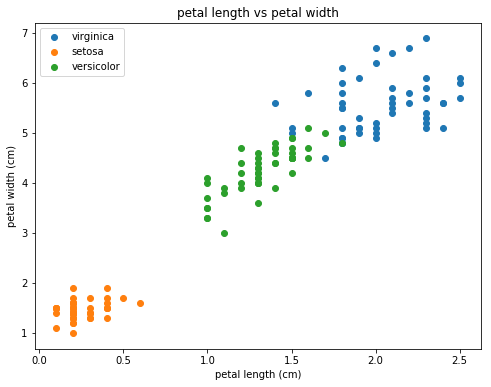

In [303]:
df['species_id'] = df['species'].map({ 'virginica': 0, 'setosa': 1, 'versicolor': 2 })

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel('petal length (cm)')
ax.set_ylabel('petal width (cm)')
ax.set_title('petal length vs petal width')

for species in ['virginica', 'setosa', 'versicolor']:
    x = df[df['species'] == species]['petal_width']
    y = df[df['species'] == species]['petal_length']
    ax.scatter(x, y, label=species)

plt.legend()

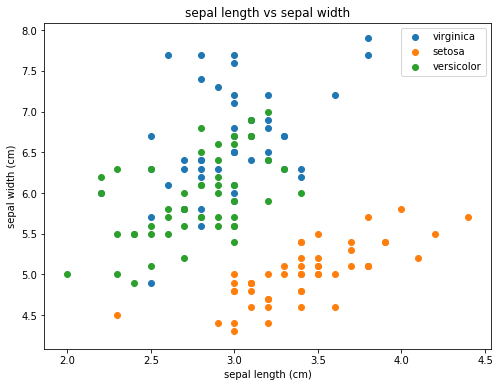

In [304]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel('sepal length (cm)')
ax.set_ylabel('sepal width (cm)')
ax.set_title('sepal length vs sepal width')

for species in ['virginica', 'setosa', 'versicolor']:
    x = df[df['species'] == species]['sepal_width']
    y = df[df['species'] == species]['sepal_length']
    ax.scatter(x, y, label=species)

plt.legend()

### Train and evaluate using train, test, split

In [305]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

y = df['species']
X = df.drop(columns=['species', 'species_id'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 1.000


In [306]:
print('depth: {}'.format(tree.tree_.max_depth))

depth: 6


### Train and evaluate using cross-validation

In [307]:
from sklearn.model_selection import cross_val_score

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X, y)
scores = cross_val_score(tree, X, y, cv=5)

print(f'mean score: {scores.mean()}')
print(f'score std: {scores.std()}')

mean score: 0.9533333333333334
score std: 0.03399346342395189


In [308]:
print('depth: {}'.format(tree.tree_.max_depth))

depth: 5


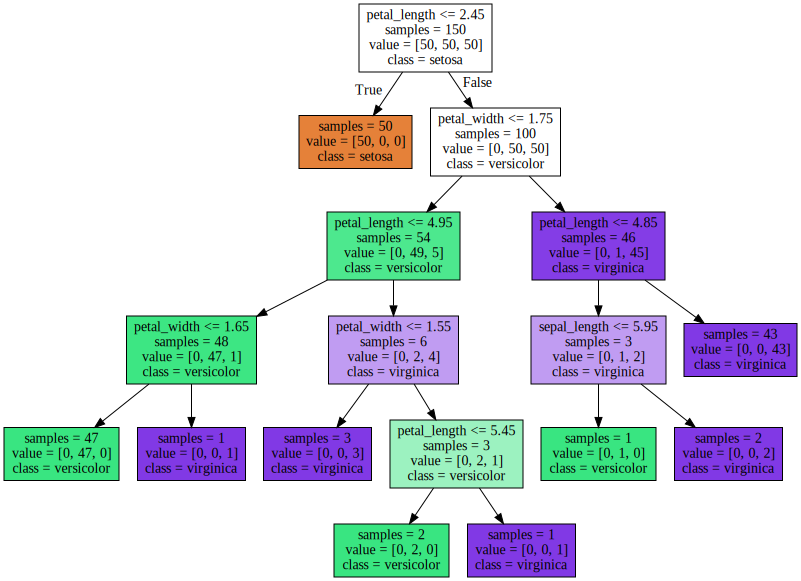

In [311]:
import graphviz
from sklearn.tree import export_graphviz

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X, y)

export_graphviz(tree, 
                out_file="tree.dot", 
                class_names=df['species'].unique(),
                feature_names=X.columns.values, 
                impurity=False, 
                filled=True)

with open("tree.dot") as f:
    dot_graph = f.read()

graphviz.Source(dot_graph)

The tree has 10 leaves.

In [312]:
# gini importances
importances = pd.DataFrame(tree.feature_importances_, X.columns.values, columns=['importance'])
importances

,importance
sepal_length,0.013333
sepal_width,0.000000
petal_length,0.564056
petal_width,0.422611


# Reducing overfitting

## Stopping by setting a maximum depth

### max_depth = 4

In [313]:
tree = DecisionTreeClassifier(random_state=42, max_depth=4)
tree.fit(X, y)

cv_scores = cross_val_score(tree, X, y, cv=5)

print('Accuracy on training set: {:.3f}'.format(tree.score(X_train, y_train))) 
print('Accuracy on test set: {:.3f}'.format(tree.score(X_test, y_test)))
print('Mean cv score: {}'.format(cv_scores.mean()))
print('cv score std: {}'.format(cv_scores.std()))

Accuracy on training set: 0.991
Accuracy on test set: 1.000
Mean cv score: 0.9533333333333334
cv score std: 0.03399346342395189


Increased score by 0.0067%

### max_depth = 3

In [314]:
tree = DecisionTreeClassifier(random_state=42, max_depth=3)
tree.fit(X, y)

cv_scores = cross_val_score(tree, X, y, cv=5)

print('Accuracy on training set: {:.3f}'.format(tree.score(X_train, y_train))) 
print('Accuracy on test set: {:.3f}'.format(tree.score(X_test, y_test)))
print('Mean cv score: {}'.format(cv_scores.mean()))
print('cv score std: {}'.format(cv_scores.std()))

Accuracy on training set: 0.964
Accuracy on test set: 1.000
Mean cv score: 0.9733333333333334
cv score std: 0.02494438257849294


Score is the same as when max_depth = 5

### Helpers functions

In [315]:
# train and evaluate the model using passed in kargs
def train_tree(**kargs):
    tree = DecisionTreeClassifier(**kargs)
    tree.fit(X, y)
    return {
        'train_set_score': tree.score(X_train, y_train),
        'test_set_score': tree.score(X_test, y_test),
        'cv_scores': cross_val_score(tree, X, y, cv=5)
    }

def print_scores(scores):
    print(f"Accuracy on training set: {scores['train_set_score']}")
    print(f"Accuracy on test set: {scores['test_set_score']}")
    print(f"Mean cv score: {scores['cv_scores'].mean()}")
    print(f"cv score std: {scores['cv_scores'].std()}") 

## Stopping by setting maximum leaves

In [321]:
# vary max_leaf_nodes from 9 to 2
value_range = range(10, 1, -1)         

scores = {v: train_tree(random_state=42, max_leaf_nodes=v) for v in value_range}
          
for value, scores in scores.items():
    print(f'max_leaf_nodes = {value}')
    print_scores(scores)
    print('\n')

max_leaf_nodes = 10
Accuracy on training set: 1.0
Accuracy on test set: 1.0
Mean cv score: 0.9600000000000002
cv score std: 0.03265986323710903


max_leaf_nodes = 9
Accuracy on training set: 1.0
Accuracy on test set: 1.0
Mean cv score: 0.9600000000000002
cv score std: 0.03265986323710903


max_leaf_nodes = 8
Accuracy on training set: 0.9910714285714286
Accuracy on test set: 1.0
Mean cv score: 0.9600000000000002
cv score std: 0.03265986323710903


max_leaf_nodes = 7
Accuracy on training set: 0.9910714285714286
Accuracy on test set: 1.0
Mean cv score: 0.9666666666666668
cv score std: 0.036514837167011066


max_leaf_nodes = 6
Accuracy on training set: 0.9821428571428571
Accuracy on test set: 1.0
Mean cv score: 0.9600000000000002
cv score std: 0.03265986323710903


max_leaf_nodes = 5
Accuracy on training set: 0.9732142857142857
Accuracy on test set: 1.0
Mean cv score: 0.9666666666666668
cv score std: 0.036514837167011066


max_leaf_nodes = 4
Accuracy on training set: 0.9642857142857143
Acc

Score is highest when max_leaf_nodes is at least 4, but it's not clear which is best.

## Stopping by setting minimum samples for splitting

In [322]:
# vary min_samples_split from 10 to 2
value_range = range(10, 1, -1)

scores = {v: train_tree(random_state=42, min_samples_split=v) for v in value_range}
          
for value, scores in scores.items():
    print(f'min_samples_split = {value}')
    print_scores(scores)
    print('\n')

min_samples_split = 10
Accuracy on training set: 0.9732142857142857
Accuracy on test set: 1.0
Mean cv score: 0.9666666666666668
cv score std: 0.02108185106778919


min_samples_split = 9
Accuracy on training set: 0.9732142857142857
Accuracy on test set: 1.0
Mean cv score: 0.9666666666666668
cv score std: 0.02108185106778919


min_samples_split = 8
Accuracy on training set: 0.9732142857142857
Accuracy on test set: 1.0
Mean cv score: 0.9666666666666668
cv score std: 0.02108185106778919


min_samples_split = 7
Accuracy on training set: 0.9732142857142857
Accuracy on test set: 1.0
Mean cv score: 0.9666666666666668
cv score std: 0.02108185106778919


min_samples_split = 6
Accuracy on training set: 0.9821428571428571
Accuracy on test set: 1.0
Mean cv score: 0.9666666666666668
cv score std: 0.02108185106778919


min_samples_split = 5
Accuracy on training set: 0.9821428571428571
Accuracy on test set: 1.0
Mean cv score: 0.9666666666666668
cv score std: 0.02108185106778919


min_samples_split = 4

Score are best when min_samples_split >= 5.

## Stopping by setting minimum samples in leaf nodes

In [323]:
# vary min_samples_leaf from 10 to 1
value_range = range(10, 0, -1)

scores = {v: train_tree(random_state=42, min_samples_leaf=v) for v in value_range}
          
for value, scores in scores.items():
    print(f'min_samples_leaf = {value}')
    print_scores(scores)
    print('\n')

min_samples_leaf = 10
Accuracy on training set: 0.9464285714285714
Accuracy on test set: 1.0
Mean cv score: 0.9333333333333332
cv score std: 0.04714045207910316


min_samples_leaf = 9
Accuracy on training set: 0.9464285714285714
Accuracy on test set: 1.0
Mean cv score: 0.9333333333333332
cv score std: 0.04714045207910316


min_samples_leaf = 8
Accuracy on training set: 0.9464285714285714
Accuracy on test set: 1.0
Mean cv score: 0.9400000000000001
cv score std: 0.04898979485566354


min_samples_leaf = 7
Accuracy on training set: 0.9464285714285714
Accuracy on test set: 1.0
Mean cv score: 0.9400000000000001
cv score std: 0.04898979485566354


min_samples_leaf = 6
Accuracy on training set: 0.9642857142857143
Accuracy on test set: 1.0
Mean cv score: 0.9400000000000001
cv score std: 0.04898979485566354


min_samples_leaf = 5
Accuracy on training set: 0.9642857142857143
Accuracy on test set: 1.0
Mean cv score: 0.9400000000000001
cv score std: 0.06110100926607785


min_samples_leaf = 4
Accura

Tuning min_samples_leaf didn't improve the score above 0.95.

## Hyperparameter tuning

### Grid search

In [332]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(3, 6)) + [None],
    'max_leaf_nodes': list(range(6, 11)) + [None],
    'min_samples_split': list(range(2, 11))
}

gs = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=10)
gs.fit(X, y)

print(f'best score: {gs.best_score_}')
for param, value in gs.best_params_.items():
    print(f'best {param} value: {value}')

best score: 0.9666666666666667
best criterion value: gini
best max_depth value: 3
best max_leaf_nodes value: 6
best min_samples_split value: 5


Confirm results

In [333]:
tree2 = DecisionTreeClassifier(**gs.best_params_)
cv_scores = cross_val_score(tree2, X, y, cv=10)
print(f'cv scores mean: {cv_scores.mean()}')
print(f'cv scores std: {cv_scores.std()}')

cv scores mean: 0.9666666666666666
cv scores std: 0.033333333333333326


### Random search





In [334]:
from sklearn.model_selection import RandomizedSearchCV

rs = RandomizedSearchCV(DecisionTreeClassifier(), param_grid, cv=10)
rs.fit(X, y)

print(f'best score: {rs.best_score_}')
for param, value in rs.best_params_.items():
    print(f'best {param} value: {value}')

best score: 0.96
best min_samples_split value: 6
best max_leaf_nodes value: 6
best max_depth value: 4
best criterion value: entropy


Confirm results

In [335]:
tree3 = DecisionTreeClassifier(**rs.best_params_)
cv_scores = cross_val_score(tree3, X, y, cv=10)
print(f'cv scores mean: {cv_scores.mean()}')
print(f'cv scores std: {cv_scores.std()}')

cv scores mean: 0.96
cv scores std: 0.03265986323710903


## Pruning

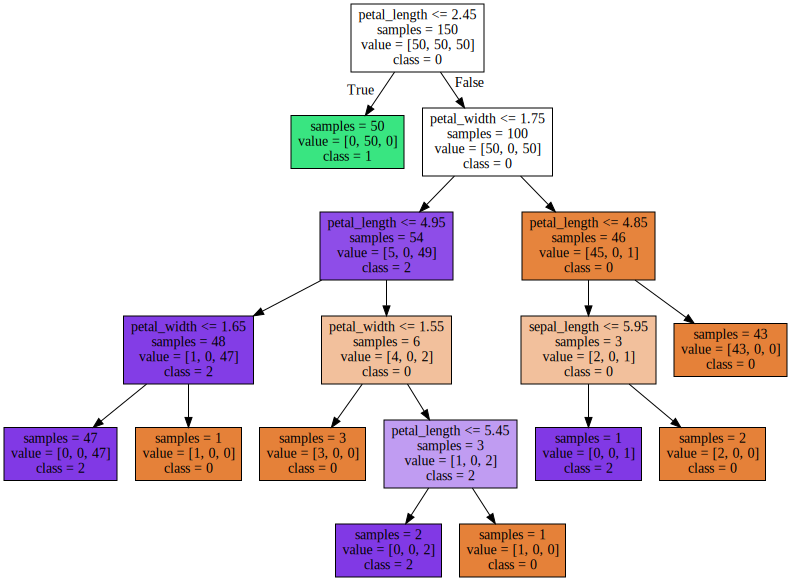

In [171]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X, y)

export_graphviz(tree, out_file="tree.dot", class_names=["0", "1", '2'],
feature_names=X.columns.values, impurity=False, filled=True)

with open("tree.dot") as f:
    dot_graph = f.read()

graphviz.Source(dot_graph)